### Import libraries

In [1]:
import pandas as pd
import numpy as np
import common
import seaborn as sns
import matplotlib.pyplot as plt
import lightgbm as lgb
from sklearn.metrics import confusion_matrix
from sklearn import metrics

### Read data

In [2]:
users = pd.read_csv('users.csv')
connections_train = pd.read_csv('connections_train.csv')
connections_train_enriched = common.enrich_dataset(connections_train, users)

connections_test = pd.read_csv('connections_test.csv')
connections_test_enriched = common.enrich_dataset(connections_test, users)

### Split into train and test

In [3]:
# columns to use for prediction
column_list = [
    'n_shared_contacts',
    'same_country',
    'same_city',
    'same_company',
    'same_discipline'
    ]

X_train = connections_train_enriched[column_list]
y_train = connections_train_enriched['added']

X_test = connections_test_enriched[column_list]
y_test = connections_test_enriched['added']

X_train.head()

,n_shared_contacts,same_country,same_city,same_company,same_discipline
0,3,1,0,0,0
1,6,1,0,1,0
2,17,1,1,1,0
3,0,1,0,0,0
4,1,1,0,0,1


### Hyperparameter optimization

In [4]:
from optuna.integration import LightGBMPruningCallback
import optuna

def objective(trial, X_, y):
    param_grid = {
        # "device_type": trial.suggest_categorical("device_type", ['gpu']),
        "n_estimators": trial.suggest_categorical("n_estimators", [100]),
        "learning_rate": trial.suggest_float("learning_rate", 0.01, 0.3),
        "num_leaves": trial.suggest_int("num_leaves", 20, 3000, step=20),
        "max_depth": trial.suggest_int("max_depth", 3, 12),
        "min_data_in_leaf": trial.suggest_int("min_data_in_leaf", 200, 10000, step=100),
        "lambda_l1": trial.suggest_int("lambda_l1", 0, 100, step=5),
        "lambda_l2": trial.suggest_int("lambda_l2", 0, 100, step=5),
        "min_gain_to_split": trial.suggest_float("min_gain_to_split", 0, 15),
        "bagging_fraction": trial.suggest_float(
            "bagging_fraction", 0.2, 0.95, step=0.1
            ),
        "bagging_freq": trial.suggest_categorical("bagging_freq", [1]),
        "feature_fraction": trial.suggest_float(
            "feature_fraction", 0.2, 0.95, step=0.1
            ),
        }

    scores = []

    model = lgb.LGBMClassifier(objective="binary", is_unbalance=True, **param_grid)
    model.fit(
        X_train,
        y_train,
        eval_set=[(X_test, y_test)],
        eval_metric="auc",
        early_stopping_rounds=100,
        callbacks=[
            LightGBMPruningCallback(trial, "binary_logloss")
        ],  # Add a pruning callback
    )
    preds = model.predict_proba(X_test)[:,1]
    scores.append(metrics.roc_auc_score(y_test, preds))

    return np.mean(scores)

In [5]:
study = optuna.create_study(direction="minimize", study_name="LGBM Classifier")
func = lambda trial: objective(trial, X_train, y_train)
study.optimize(func, n_trials=20, )

[I 2022-03-09 02:43:36,058] A new study created in memory with name: LGBM Classifier
/home/joao/.local/lib/python3.9/site-packages/optuna/distributions.py:545: UserWarning: The distribution is specified by [0.2, 0.95] and q=0.1, but the range is not divisible by `q`. It will be replaced by [0.2, 0.9].
  warnings.warn(
/home/joao/.local/lib/python3.9/site-packages/lightgbm/sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "


[LightGBM] [Warning] lambda_l1 is set=100, reg_alpha=0.0 will be ignored. Current value: lambda_l1=100
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] min_gain_to_split is set=7.920559477191953, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=7.920559477191953
[LightGBM] [Warning] lambda_l2 is set=70, reg_lambda=0.0 will be ignored. Current value: lambda_l2=70
[LightGBM] [Warning] feature_fraction is set=0.4, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.4
[LightGBM] [Warning] min_data_in_leaf is set=7800, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=7800
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[I 2022-03-09 02:43:39,690] Trial 0 finished with value: 0.9818039144277015 and parameters: {'n_estimators': 100, 'learning_rate': 0.18071129199897104, 'num_leaves': 1960, 'max_depth': 10, 'min_data_in_leaf': 7800, 'lambda_l1': 100, 'lambda_l2': 70, 'min_gain_to_split': 7.920559477191953, 'bagging_fraction': 0.8, 'bagging_freq': 1, 'feature_fraction': 0.4}. Best is trial 0 with value: 0.9818039144277015.
/home/joao/.local/lib/python3.9/site-packages/optuna/distributions.py:545: UserWarning: The distribution is specified by [0.2, 0.95] and q=0.1, but the range is not divisible by `q`. It will be replaced by [0.2, 0.9].
  warnings.warn(
/home/joao/.local/lib/python3.9/site-packages/lightgbm/sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of 

[LightGBM] [Warning] lambda_l1 is set=60, reg_alpha=0.0 will be ignored. Current value: lambda_l1=60
[LightGBM] [Warning] bagging_fraction is set=0.6000000000000001, subsample=1.0 will be ignored. Current value: bagging_fraction=0.6000000000000001
[LightGBM] [Warning] min_gain_to_split is set=8.913928365891008, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=8.913928365891008
[LightGBM] [Warning] lambda_l2 is set=55, reg_lambda=0.0 will be ignored. Current value: lambda_l2=55
[LightGBM] [Warning] feature_fraction is set=0.30000000000000004, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.30000000000000004
[LightGBM] [Warning] min_data_in_leaf is set=2100, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=2100
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[I 2022-03-09 02:43:43,379] Trial 1 finished with value: 0.982109234872291 and parameters: {'n_estimators': 100, 'learning_rate': 0.26371319997925446, 'num_leaves': 1120, 'max_depth': 4, 'min_data_in_leaf': 2100, 'lambda_l1': 60, 'lambda_l2': 55, 'min_gain_to_split': 8.913928365891008, 'bagging_fraction': 0.6000000000000001, 'bagging_freq': 1, 'feature_fraction': 0.30000000000000004}. Best is trial 0 with value: 0.9818039144277015.
/home/joao/.local/lib/python3.9/site-packages/optuna/distributions.py:545: UserWarning: The distribution is specified by [0.2, 0.95] and q=0.1, but the range is not divisible by `q`. It will be replaced by [0.2, 0.9].
  warnings.warn(
/home/joao/.local/lib/python3.9/site-packages/lightgbm/sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be rem

[LightGBM] [Warning] lambda_l1 is set=80, reg_alpha=0.0 will be ignored. Current value: lambda_l1=80
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] min_gain_to_split is set=7.158249289416839, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=7.158249289416839
[LightGBM] [Warning] lambda_l2 is set=70, reg_lambda=0.0 will be ignored. Current value: lambda_l2=70
[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] min_data_in_leaf is set=9100, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=9100
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[I 2022-03-09 02:43:47,918] Trial 2 finished with value: 0.987840277485738 and parameters: {'n_estimators': 100, 'learning_rate': 0.09686452995506549, 'num_leaves': 1920, 'max_depth': 10, 'min_data_in_leaf': 9100, 'lambda_l1': 80, 'lambda_l2': 70, 'min_gain_to_split': 7.158249289416839, 'bagging_fraction': 0.8, 'bagging_freq': 1, 'feature_fraction': 0.9}. Best is trial 0 with value: 0.9818039144277015.
/home/joao/.local/lib/python3.9/site-packages/optuna/distributions.py:545: UserWarning: The distribution is specified by [0.2, 0.95] and q=0.1, but the range is not divisible by `q`. It will be replaced by [0.2, 0.9].
  warnings.warn(
/home/joao/.local/lib/python3.9/site-packages/lightgbm/sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of Li

[LightGBM] [Warning] lambda_l1 is set=15, reg_alpha=0.0 will be ignored. Current value: lambda_l1=15
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] min_gain_to_split is set=2.0899003198467296, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=2.0899003198467296
[LightGBM] [Warning] lambda_l2 is set=35, reg_lambda=0.0 will be ignored. Current value: lambda_l2=35
[LightGBM] [Warning] feature_fraction is set=0.30000000000000004, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.30000000000000004
[LightGBM] [Warning] min_data_in_leaf is set=9500, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=9500
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[I 2022-03-09 02:43:52,088] Trial 3 finished with value: 0.9780299963749183 and parameters: {'n_estimators': 100, 'learning_rate': 0.02476897704168195, 'num_leaves': 2460, 'max_depth': 8, 'min_data_in_leaf': 9500, 'lambda_l1': 15, 'lambda_l2': 35, 'min_gain_to_split': 2.0899003198467296, 'bagging_fraction': 0.9, 'bagging_freq': 1, 'feature_fraction': 0.30000000000000004}. Best is trial 3 with value: 0.9780299963749183.
/home/joao/.local/lib/python3.9/site-packages/optuna/distributions.py:545: UserWarning: The distribution is specified by [0.2, 0.95] and q=0.1, but the range is not divisible by `q`. It will be replaced by [0.2, 0.9].
  warnings.warn(
/home/joao/.local/lib/python3.9/site-packages/lightgbm/sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a fut

[LightGBM] [Warning] lambda_l1 is set=25, reg_alpha=0.0 will be ignored. Current value: lambda_l1=25
[LightGBM] [Warning] bagging_fraction is set=0.5, subsample=1.0 will be ignored. Current value: bagging_fraction=0.5
[LightGBM] [Warning] min_gain_to_split is set=8.495056090740905, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=8.495056090740905
[LightGBM] [Warning] lambda_l2 is set=75, reg_lambda=0.0 will be ignored. Current value: lambda_l2=75
[LightGBM] [Warning] feature_fraction is set=0.5, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5
[LightGBM] [Warning] min_data_in_leaf is set=8500, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=8500
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[I 2022-03-09 02:43:57,301] Trial 4 finished with value: 0.984651529992174 and parameters: {'n_estimators': 100, 'learning_rate': 0.017280255645670362, 'num_leaves': 140, 'max_depth': 6, 'min_data_in_leaf': 8500, 'lambda_l1': 25, 'lambda_l2': 75, 'min_gain_to_split': 8.495056090740905, 'bagging_fraction': 0.5, 'bagging_freq': 1, 'feature_fraction': 0.5}. Best is trial 3 with value: 0.9780299963749183.
/home/joao/.local/lib/python3.9/site-packages/optuna/distributions.py:545: UserWarning: The distribution is specified by [0.2, 0.95] and q=0.1, but the range is not divisible by `q`. It will be replaced by [0.2, 0.9].
  warnings.warn(
/home/joao/.local/lib/python3.9/site-packages/lightgbm/sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of Lig

[LightGBM] [Warning] lambda_l1 is set=25, reg_alpha=0.0 will be ignored. Current value: lambda_l1=25
[LightGBM] [Warning] bagging_fraction is set=0.30000000000000004, subsample=1.0 will be ignored. Current value: bagging_fraction=0.30000000000000004
[LightGBM] [Warning] min_gain_to_split is set=13.492406709312425, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=13.492406709312425
[LightGBM] [Warning] lambda_l2 is set=50, reg_lambda=0.0 will be ignored. Current value: lambda_l2=50
[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] min_data_in_leaf is set=600, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=600
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[I 2022-03-09 02:44:01,266] Trial 5 finished with value: 0.9879914705678527 and parameters: {'n_estimators': 100, 'learning_rate': 0.285236368115128, 'num_leaves': 1820, 'max_depth': 12, 'min_data_in_leaf': 600, 'lambda_l1': 25, 'lambda_l2': 50, 'min_gain_to_split': 13.492406709312425, 'bagging_fraction': 0.30000000000000004, 'bagging_freq': 1, 'feature_fraction': 0.7}. Best is trial 3 with value: 0.9780299963749183.
/home/joao/.local/lib/python3.9/site-packages/optuna/distributions.py:545: UserWarning: The distribution is specified by [0.2, 0.95] and q=0.1, but the range is not divisible by `q`. It will be replaced by [0.2, 0.9].
  warnings.warn(
/home/joao/.local/lib/python3.9/site-packages/lightgbm/sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a futur

[LightGBM] [Warning] lambda_l1 is set=45, reg_alpha=0.0 will be ignored. Current value: lambda_l1=45
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] min_gain_to_split is set=4.393102567148754, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=4.393102567148754
[LightGBM] [Warning] lambda_l2 is set=90, reg_lambda=0.0 will be ignored. Current value: lambda_l2=90
[LightGBM] [Warning] feature_fraction is set=0.5, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5
[LightGBM] [Warning] min_data_in_leaf is set=4200, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=4200
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[I 2022-03-09 02:44:05,485] Trial 6 finished with value: 0.9881433753828002 and parameters: {'n_estimators': 100, 'learning_rate': 0.17134817685126355, 'num_leaves': 1400, 'max_depth': 8, 'min_data_in_leaf': 4200, 'lambda_l1': 45, 'lambda_l2': 90, 'min_gain_to_split': 4.393102567148754, 'bagging_fraction': 0.9, 'bagging_freq': 1, 'feature_fraction': 0.5}. Best is trial 3 with value: 0.9780299963749183.
/home/joao/.local/lib/python3.9/site-packages/optuna/distributions.py:545: UserWarning: The distribution is specified by [0.2, 0.95] and q=0.1, but the range is not divisible by `q`. It will be replaced by [0.2, 0.9].
  warnings.warn(
/home/joao/.local/lib/python3.9/site-packages/lightgbm/sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of Li

[LightGBM] [Warning] lambda_l1 is set=20, reg_alpha=0.0 will be ignored. Current value: lambda_l1=20
[LightGBM] [Warning] bagging_fraction is set=0.30000000000000004, subsample=1.0 will be ignored. Current value: bagging_fraction=0.30000000000000004
[LightGBM] [Warning] min_gain_to_split is set=7.237065335445148, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=7.237065335445148
[LightGBM] [Warning] lambda_l2 is set=55, reg_lambda=0.0 will be ignored. Current value: lambda_l2=55
[LightGBM] [Warning] feature_fraction is set=0.6000000000000001, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6000000000000001
[LightGBM] [Warning] min_data_in_leaf is set=600, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=600
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[I 2022-03-09 02:44:05,793] Trial 7 pruned. Trial was pruned at iteration 0.
/home/joao/.local/lib/python3.9/site-packages/optuna/distributions.py:545: UserWarning: The distribution is specified by [0.2, 0.95] and q=0.1, but the range is not divisible by `q`. It will be replaced by [0.2, 0.9].
  warnings.warn(
/home/joao/.local/lib/python3.9/site-packages/lightgbm/sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
[I 2022-03-09 02:44:06,086] Trial 8 pruned. Trial was pruned at iteration 0.
/home/joao/.local/lib/python3.9/site-packages/optuna/distributions.py:545: UserWarning: The distribution is specified by [0.2, 0.95] and q=0.1, but the range is not divisible by `q`. It will be replaced by [0.2, 0.9].
  warnings.warn(
/home/j

[LightGBM] [Warning] lambda_l1 is set=10, reg_alpha=0.0 will be ignored. Current value: lambda_l1=10
[LightGBM] [Warning] bagging_fraction is set=0.2, subsample=1.0 will be ignored. Current value: bagging_fraction=0.2
[LightGBM] [Warning] min_gain_to_split is set=11.22447294646085, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=11.22447294646085
[LightGBM] [Warning] lambda_l2 is set=85, reg_lambda=0.0 will be ignored. Current value: lambda_l2=85
[LightGBM] [Warning] feature_fraction is set=0.2, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.2
[LightGBM] [Warning] min_data_in_leaf is set=8400, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=8400
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[I 2022-03-09 02:44:12,921] Trial 17 pruned. Trial was pruned at iteration 0.
/home/joao/.local/lib/python3.9/site-packages/optuna/distributions.py:545: UserWarning: The distribution is specified by [0.2, 0.95] and q=0.1, but the range is not divisible by `q`. It will be replaced by [0.2, 0.9].
  warnings.warn(
/home/joao/.local/lib/python3.9/site-packages/lightgbm/sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
[I 2022-03-09 02:44:17,075] Trial 18 finished with value: 0.9878011467381165 and parameters: {'n_estimators': 100, 'learning_rate': 0.11414998587253294, 'num_leaves': 1560, 'max_depth': 6, 'min_data_in_leaf': 6500, 'lambda_l1': 35, 'lambda_l2': 40, 'min_gain_to_split': 14.926090558704564, 'bagging_fraction': 0.8, 'ba

[LightGBM] [Warning] lambda_l1 is set=60, reg_alpha=0.0 will be ignored. Current value: lambda_l1=60
[LightGBM] [Warning] bagging_fraction is set=0.5, subsample=1.0 will be ignored. Current value: bagging_fraction=0.5
[LightGBM] [Warning] min_gain_to_split is set=5.870070006791554, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=5.870070006791554
[LightGBM] [Warning] lambda_l2 is set=40, reg_lambda=0.0 will be ignored. Current value: lambda_l2=40
[LightGBM] [Warning] feature_fraction is set=0.4, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.4
[LightGBM] [Warning] min_data_in_leaf is set=4400, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=4400
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[I 2022-03-09 02:44:17,452] Trial 19 pruned. Trial was pruned at iteration 0.


In [6]:
print(f"\tBest value (auc): {study.best_value:.5f}")
print(f"\tBest params:")

for key, value in study.best_params.items():
    print(f"\t\t{key}: {value}")

	Best value (auc): 0.97803
	Best params:
		n_estimators: 100
		learning_rate: 0.02476897704168195
		num_leaves: 2460
		max_depth: 8
		min_data_in_leaf: 9500
		lambda_l1: 15
		lambda_l2: 35
		min_gain_to_split: 2.0899003198467296
		bagging_fraction: 0.9
		bagging_freq: 1
		feature_fraction: 0.30000000000000004


### Train classifier with optimum parameters

In [7]:
# Train classifier
clf = lgb.LGBMClassifier(
    is_unbalance=True,
    metric='auc',
    n_estimators=100,
    learning_rate=0.11940264791618968,
    num_leaves=2640,
    max_depth=6,
    min_data_in_leaf=9800,
    lambda_l1=25,
    lambda_l2=70,
    min_gain_to_split=11.785244996711167,
    bagging_fraction=0.4,
    bagging_freq=1,
    feature_fraction=0.2
)
clf.fit(X_train, y_train);

# predict results
y_pred=clf.predict(X_test)

### Evaluate performance

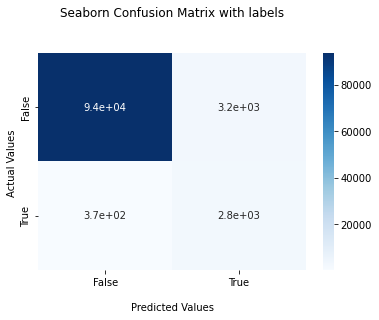

In [8]:
# confusion matrix
cm = confusion_matrix(y_test, y_pred)
ax = sns.heatmap(cm, annot=True, cmap='Blues')

ax.set_title('Seaborn Confusion Matrix with labels\n\n');
ax.set_xlabel('\nPredicted Values')
ax.set_ylabel('Actual Values ');

ax.xaxis.set_ticklabels(['False','True'])
ax.yaxis.set_ticklabels(['False','True'])

plt.show()

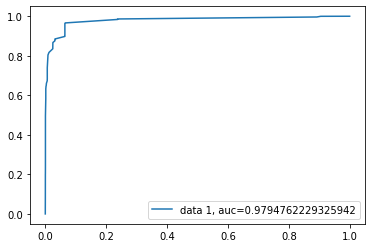

In [9]:
y_pred_proba = clf.predict_proba(X_test)[:,1]

fpr, tpr, _ = metrics.roc_curve(y_test,  y_pred_proba)
auc = metrics.roc_auc_score(y_test, y_pred_proba)
plt.plot(fpr,tpr,label="data 1, auc="+str(auc))
plt.legend(loc=4)
plt.show()

### What is the performance of the top n recommendated connections?

In [10]:
def calc_hr_top_n(connections_test_enriched, y_pred_proba, y_test, n_rec, print_text=True):

    # How many recommendations per are there per user in the test dataset?
    num_rec_per_user = connections_test_enriched.groupby(by='user_id_x').count()['recommended_contact_id']
    num_rec_per_user = num_rec_per_user.reset_index()
    num_rec_per_user = num_rec_per_user.rename(columns={'user_id_x': 'user_id', 'recommended_contact_id': 'num_rec_contacts'})
    num_rec_per_user['hr_model'] = None
    num_rec_per_user['hr_random'] = None

    # Create dataframe to store the performance results
    connections_proba = connections_test_enriched.copy()
    connections_proba = connections_proba.rename(columns={'user_id_x': 'user_id'})
    connections_proba['prob'] = y_pred_proba
    connections_proba['added'] = y_test

    # What's the prediction for the top 5 recommendated connections?
    for idx, row in num_rec_per_user.iterrows(): # this is a quick solution, not the most efficient

        current_user = row['user_id']

        if row['num_rec_contacts'] >= n_rec:

            # filter recommendations for this user
            current_user_df = connections_proba[connections_proba['user_id'] == current_user]

            # get the top 5 with the highest probability
            current_user_df_top_n = current_user_df.sort_values(by='prob', ascending=False).head(n_rec)

            # mean hit rates
            hr_model = np.mean(current_user_df_top_n['added'])
            hr_rnd = np.mean(current_user_df['added'])

            # save the result
            num_rec_per_user.loc[num_rec_per_user['user_id'] == current_user, 'hr_model'] = hr_model
            num_rec_per_user.loc[num_rec_per_user['user_id'] == current_user, 'hr_random'] = hr_rnd

    # Calculate the mean hitrate for each case
    mean_hr_model = np.mean(num_rec_per_user[~num_rec_per_user['hr_model'].isnull()]['hr_model'])
    mean_hr_rnd = np.mean(num_rec_per_user[~num_rec_per_user['hr_random'].isnull()]['hr_random'])
    
    if print_text:
        print('Mean hitrate using random recommendations = {}'.format(mean_hr_rnd))
        print('Mean hitrate using top {} model recommendations = {}'.format(n_rec, mean_hr_model))
        print('The top {} model recommendations have a mean hitrate {}% higher than random recommendations'.format(n_rec, np.round((100*mean_hr_model/mean_hr_rnd), 2)))

    return (n_rec, mean_hr_rnd, mean_hr_model)

In [11]:
print('n = 5')
calc_hr_top_n(connections_test_enriched, y_pred_proba, y_test, n_rec=5);
print('  ')
print('n = 10')
calc_hr_top_n(connections_test_enriched, y_pred_proba, y_test, n_rec=10);

n = 5
Mean hitrate using random recommendations = 0.0003435153650562902
Mean hitrate using top 5 model recommendations = 0.00294323756131745
The top 5 model recommendations have a mean hitrate 856.8% higher than random recommendations
  
n = 10
Mean hitrate using random recommendations = 0.0003669134924665614
Mean hitrate using top 10 model recommendations = 0.0016467065868263477
The top 10 model recommendations have a mean hitrate 448.8% higher than random recommendations


In [12]:
# How does the hit rate evolve with the number of recommendations?

result_list = []

for n in range(3, 11):    
    result = calc_hr_top_n(connections_test_enriched, y_pred_proba, y_test, n_rec=n, print_text=False)
    result_list.append(result)
    
result_df = pd.DataFrame(result_list)
result_df.columns = ['n_rec', 'mean_hr_rnd', 'mean_hr_model']

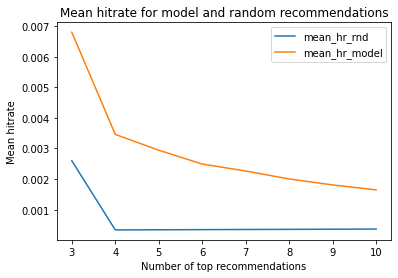

In [13]:
result_df.plot(
    x='n_rec',
    y=['mean_hr_rnd', 'mean_hr_model'],
    title='Mean hitrate for model and random recommendations',
    xlabel='Number of top recommendations',
    ylabel='Mean hitrate'
    );

### Explain the model results

In [14]:
import shap
shap.initjs()
explainer = shap.TreeExplainer(clf)
shap_values = explainer.shap_values(X_test)

LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


In [16]:
# Explain one case from the test dataset
case_to_explain=0

print('dataset used for this case')
print(X_test.iloc[[case_to_explain]])

print('Prediction = {}'.format(y_pred[case_to_explain]))
print('Actual value = {}'.format(y_test[case_to_explain]))

shap.force_plot(explainer.expected_value[1], shap_values[1][case_to_explain,:], X_test.iloc[case_to_explain,:])

dataset used for this case
   n_shared_contacts  same_country  same_city  same_company  same_discipline
0                  0             1          0             0                1
Prediction = False
Actual value = False


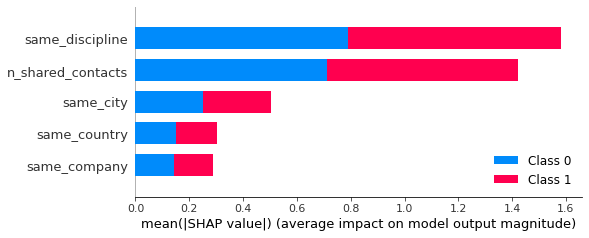

In [17]:
# Summary of the influence of each variable
shap.summary_plot(shap_values, X_test)

## What would be the performance using a rolling time window?

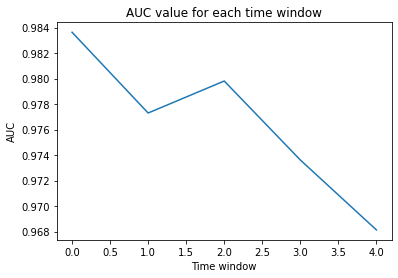

In [18]:
# define the time windows to use for train and test
# the model will be trained on 400000 rows and applied on the following 200000 rows to assess performance

windows = [
    {'train_start': 0,      'train_end': 399999, 'test_start':400000, 'test_end':499999},
    {'train_start': 100000, 'train_end': 499999, 'test_start':500000, 'test_end':599999},
    {'train_start': 200000, 'train_end': 599999, 'test_start':600000, 'test_end':699999},
    {'train_start': 300000, 'train_end': 699999, 'test_start':700000, 'test_end':799999},
    {'train_start': 400000, 'train_end': 799999, 'test_start':800000, 'test_end':899999}
]

# Creates DataFrame.
windows_df = pd.DataFrame(windows)

auc_list = []

for window in windows:
    X_train_w = connections_train_enriched[column_list][window.get('train_start'):window.get('train_end')+1]
    y_train_w = connections_train_enriched['added'][window.get('train_start'):window.get('train_end')+1]

    X_test_w = connections_train_enriched[column_list][window.get('test_start'):window.get('test_end')+1]
    y_test_w = connections_train_enriched['added'][window.get('test_start'):window.get('test_end')+1]

    # Train classifier
    clf_w = lgb.LGBMClassifier(
        is_unbalance=True,
        metric='auc'
    )
    clf_w.fit(X_train_w, y_train_w)
    
    # predict results
    y_pred_proba_w = clf.predict_proba(X_test_w)[:,1]
    
    auc = metrics.roc_auc_score(y_test_w, y_pred_proba_w)
    auc_list.append(auc)
    
plt.plot(auc_list)
plt.title('AUC value for each time window')
plt.xlabel('Time window')
plt.ylabel('AUC')
plt.show()